In [1]:
cd ../

/media/beast/ds-drive/github/predictive-maintenance/ml


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

%matplotlib inline

In [3]:
data_dir = 'data/dataset/'

In [4]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
maint = pd.read_csv(f'{data_dir}PdM_maint.csv')
machines = pd.read_csv(f'{data_dir}PdM_machines.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')
errors = pd.read_csv(f'{data_dir}PdM_errors.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**errors.csv** The errors logs are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

**maint.csv** This file contains the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections.

**machines.csv** This data set includes some information about the machines which are model type and years in service.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Vis.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
telemetry.machineID.nunique()

100

In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [9]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [10]:
machines.machineID.nunique()

100

In [11]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [12]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [13]:
print(telemetry.machineID.nunique())
print(maint.machineID.nunique())
print(machines.machineID.nunique())
print(failures.machineID.nunique())
print(errors.machineID.nunique())

100
100
100
98
100


## Prepare Data

In [14]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [15]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [16]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [17]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [21]:
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [31]:
# errors

errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print('Total number of error records: {}'.format(len(errors)))
errors.head()

Total number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


Text(0, 0.5, 'Count')

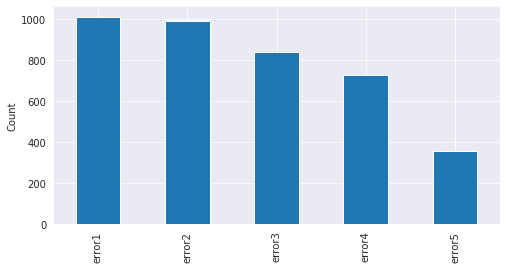

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')

In [28]:
# maintenance

maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print('Total number of maintenance records: {}'.format(len(maint)))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


Text(0, 0.5, 'Count')

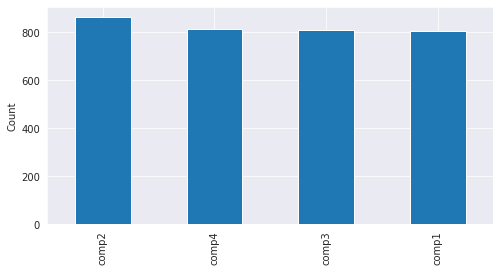

In [29]:
plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')

In [33]:
# machines

machines['model'] = machines['model'].astype('category')

print('Total number of machines: {}'.format(len(machines.index)))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [34]:
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

In [35]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

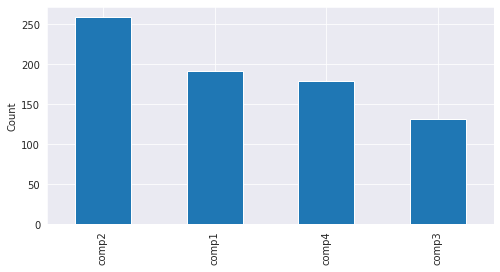

In [37]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

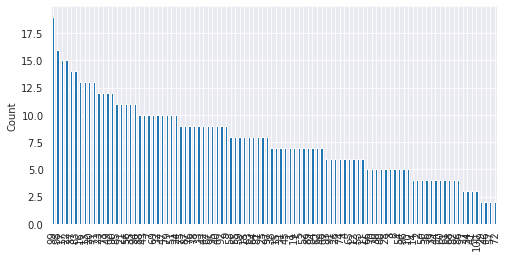

In [38]:
plt.figure(figsize=(8, 4))
failures['machineID'].value_counts().plot(kind='bar')
plt.ylabel('Count')